In [103]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

In [104]:
# Dominio de -1 a 1 en 64 datos debibo a los 6 genes
# 000 000, 000 001, ... , 111 111
x = np.linspace(-1, 1, 64)
y = x**2

print(x)
print(y)

[-1.         -0.96825397 -0.93650794 -0.9047619  -0.87301587 -0.84126984
 -0.80952381 -0.77777778 -0.74603175 -0.71428571 -0.68253968 -0.65079365
 -0.61904762 -0.58730159 -0.55555556 -0.52380952 -0.49206349 -0.46031746
 -0.42857143 -0.3968254  -0.36507937 -0.33333333 -0.3015873  -0.26984127
 -0.23809524 -0.20634921 -0.17460317 -0.14285714 -0.11111111 -0.07936508
 -0.04761905 -0.01587302  0.01587302  0.04761905  0.07936508  0.11111111
  0.14285714  0.17460317  0.20634921  0.23809524  0.26984127  0.3015873
  0.33333333  0.36507937  0.3968254   0.42857143  0.46031746  0.49206349
  0.52380952  0.55555556  0.58730159  0.61904762  0.65079365  0.68253968
  0.71428571  0.74603175  0.77777778  0.80952381  0.84126984  0.87301587
  0.9047619   0.93650794  0.96825397  1.        ]
[1.00000000e+00 9.37515747e-01 8.77047115e-01 8.18594104e-01
 7.62156715e-01 7.07734946e-01 6.55328798e-01 6.04938272e-01
 5.56563366e-01 5.10204082e-01 4.65860418e-01 4.23532376e-01
 3.83219955e-01 3.44923154e-01 3.08641

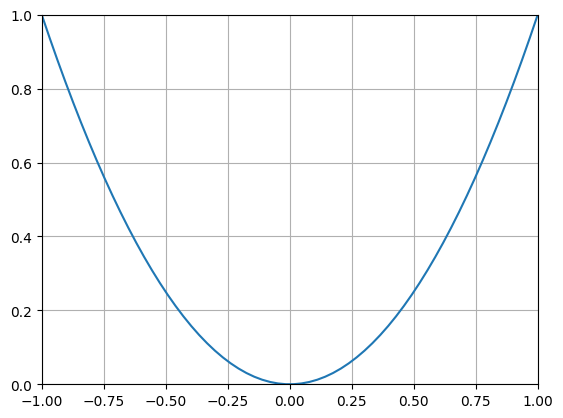

In [105]:
plt.plot(x, y)
plt.axis([-1, 1, 0, 1])
plt.grid(True)
plt.show()

No es necesario tener toda la poblacion generada, habra casos donde no se pueda generar todos y solo necesitamos 10 individuos para empezar la cruza, el objetivo es justamente con una poblacion pequeña alcanzar lo optimo.

# Generar Poblacion

In [106]:
step = 64
valores = np.linspace(-1, 1, step)  # 64 valores entre -1 y 1

def bin2val(binario, valores):
    idx = int(binario, 2)
    return valores[idx]

def generar_individuo():
    # Índice entre 0 y 63
    idx = random.randint(0, step-1)
    # Decimal a Binario
    binario = format(idx, '06b')
    valor = bin2val(binario, valores)
    return binario, valor

# Generar padres
padres = []
val = []
for _ in range(10):
    b, v = generar_individuo()
    padres.append(b)
    val.append(v)
    print(f"{b} -> {v}")


000001 -> -0.9682539682539683
001110 -> -0.5555555555555556
010001 -> -0.46031746031746035
111001 -> 0.8095238095238093
110000 -> 0.5238095238095237
011001 -> -0.2063492063492064
110011 -> 0.6190476190476191
001000 -> -0.746031746031746
010111 -> -0.2698412698412699
111100 -> 0.9047619047619047


Creamos nuestra poblacion inicial junto con su aptitud

In [107]:
df = pd.DataFrame({
    'Bin': padres,
    'Valor': val
})
df['fitness'] = df['Valor']**2

In [108]:
display(df)

,Bin,Valor,fitness
0,000001,-0.968254,0.937516
1,001110,-0.555556,0.308642
2,010001,-0.460317,0.211892
3,111001,0.809524,0.655329
4,110000,0.523810,0.274376
5,011001,-0.206349,0.042580
6,110011,0.619048,0.383220
7,001000,-0.746032,0.556563
8,010111,-0.269841,0.072814
9,111100,0.904762,0.818594


Ordenar segun su aptitud

In [109]:
df.sort_values(by='fitness', ascending=False, inplace=True)
df.reset_index(drop=True, inplace=True)
#df.to_csv('poblacion_inicial.csv', index=False) # Guardar para replicar despues
display(df)

,Bin,Valor,fitness
0,000001,-0.968254,0.937516
1,111100,0.904762,0.818594
2,111001,0.809524,0.655329
3,001000,-0.746032,0.556563
4,110011,0.619048,0.383220
5,001110,-0.555556,0.308642
6,110000,0.523810,0.274376
7,010001,-0.460317,0.211892
8,010111,-0.269841,0.072814
9,011001,-0.206349,0.042580


Llevaremos un registro de las generaciones para lo cual tomaremos dos valores representativos de cada generacion, siendo estos el mejor valor de aptitud asi como el promedio de la generacion.  
Partiendo de los padres inicales esta sera nuestra Generacion 0.

In [110]:
df_hist = pd.DataFrame(columns=["Bin","Valor","fitness", "Avg_Fitness"])

def add_hist (df, df_hist):
    nuevo_registro = df.iloc[[0]].copy()
    nuevo_registro["Avg_Fitness"] = df["fitness"].mean()
    df_hist = pd.concat([df_hist, nuevo_registro], ignore_index=True)
    return df_hist

In [111]:
df_hist = add_hist(df, df_hist)
print(df_hist)

      Bin     Valor   fitness  Avg_Fitness
0  000001 -0.968254  0.937516     0.426153


C:\Users\death\AppData\Local\Temp\ipykernel_23728\3672471164.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_hist = pd.concat([df_hist, nuevo_registro], ignore_index=True)


# Seleccion

Con nuestros 10 padres creados procedemos a la cruza  
Para esto haremos 5 parejas y cada una tendra 2 hijos


## Metodos de selección

Separaremos los padres en dos grupos segun su aptitud y usaremos dos metodos de selección, Rank y Torneo

Como proponemos 5 parejas y debido a sus aptitudes haremos 2 parejas con rank (Las que tienen mejor aptitud) y 3 por torneo(Con peor aptitud esperando que mejoren)

In [112]:
# Rank
df1 = df.iloc[:4]

# torneo
df2 = df.iloc[4:10]

In [113]:
display(df1)
display(df2)

,Bin,Valor,fitness
0,000001,-0.968254,0.937516
1,111100,0.904762,0.818594
2,111001,0.809524,0.655329
3,001000,-0.746032,0.556563


,Bin,Valor,fitness
4,110011,0.619048,0.383220
5,001110,-0.555556,0.308642
6,110000,0.523810,0.274376
7,010001,-0.460317,0.211892
8,010111,-0.269841,0.072814
9,011001,-0.206349,0.042580


### Rank
Formaremos parejas segun su rango de aptitud tomando asi:  
(1 - 2), (3 - 4), (5 - 6)...(n-1, n)

In [114]:
df_rs = df1.reset_index(drop=True) # Reiniciar índice para hacer nuestra cruza
display(df_rs)

,Bin,Valor,fitness
0,000001,-0.968254,0.937516
1,111100,0.904762,0.818594
2,111001,0.809524,0.655329
3,001000,-0.746032,0.556563


### Implementacion Cruza
En este punto implementamos tambien nuestro metodo de cruza el cual sera por k-cortes, que en este caso usaremos K = 1

In [115]:
def parejas_rank(df):
    df_rs = df.reset_index(drop=True)
    parejas = []
    for i in range(0, len(df_rs)-1, 2):
        if i+1 < len(df_rs):
            pareja = (df_rs.iloc[i], df_rs.iloc[i+1])
            parejas.append(pareja)
    return parejas

def cruza_corte(parejas, corte_n):
    hijos = []
    for p1, p2 in parejas:
        bin1 = p1['Bin']
        bin2 = p2['Bin']
        hijo1_bin = bin1[:corte_n] + bin2[corte_n:]
        hijo2_bin = bin2[:corte_n] + bin1[corte_n:]
        hijos.append(hijo1_bin)
        hijos.append(hijo2_bin)
    return hijos


In [116]:
parejas = parejas_rank(df1)
hijos_binarios = cruza_corte(parejas, 3)

for idx, (p1, p2) in enumerate(parejas):
    print(f"Pareja {idx+1}:")
    print("Padre 1 Bin:", p1['Bin'])
    print("Padre 2 Bin:", p2['Bin'])
    print("---")

for idx, hijo_bin in enumerate(hijos_binarios):
    print(f"Hijo {idx+1} Bin:", hijo_bin)

Pareja 1:
Padre 1 Bin: 000001
Padre 2 Bin: 111100
---
Pareja 2:
Padre 1 Bin: 111001
Padre 2 Bin: 001000
---
Hijo 1 Bin: 000100
Hijo 2 Bin: 111001
Hijo 3 Bin: 111000
Hijo 4 Bin: 001001


In [117]:
gen1 = pd.DataFrame(hijos_binarios, columns=['Bin'])
gen1['Valor'] = gen1['Bin'].apply(lambda b: bin2val(b, valores))
gen1['fitness'] = gen1['Valor']**2

gen1_r = pd.concat([df_rs, gen1], ignore_index=True)

In [118]:
gen1_r.sort_values(by='fitness', ascending=False, inplace=True)
display(gen1_r)

,Bin,Valor,fitness
0,000001,-0.968254,0.937516
1,111100,0.904762,0.818594
4,000100,-0.873016,0.762157
2,111001,0.809524,0.655329
5,111001,0.809524,0.655329
6,111000,0.777778,0.604938
3,001000,-0.746032,0.556563
7,001001,-0.714286,0.510204


### Torneo

En una lista de n elementos formaremos parejas la siguiente manera:  
(1 - n), (2 - n-1), (3 - n-2) y asi sucesivamente

In [119]:
df_ts = df2.reset_index(drop=True)
display(df_ts)

,Bin,Valor,fitness
0,110011,0.619048,0.383220
1,001110,-0.555556,0.308642
2,110000,0.523810,0.274376
3,010001,-0.460317,0.211892
4,010111,-0.269841,0.072814
5,011001,-0.206349,0.042580


In [120]:
def parejas_tournament(df):
    df_rs = df.reset_index(drop=True)
    parejas = []
    n = len(df_rs)
    for i in range(n // 2):
        pareja = (df_rs.iloc[i], df_rs.iloc[n - 1 - i])
        parejas.append(pareja)
    return parejas

parejas = parejas_tournament(df2)
hijos_binarios = cruza_corte(parejas, 3)
for idx, (p1, p2) in enumerate(parejas):
    print(f"Pareja {idx+1}:")
    print("Padre 1 Bin:", p1['Bin'])
    print("Padre 2 Bin:", p2['Bin'])
    print("---")

for idx, hijo_bin in enumerate(hijos_binarios):
    print(f"Hijo {idx+1} Bin:", hijo_bin)

Pareja 1:
Padre 1 Bin: 110011
Padre 2 Bin: 011001
---
Pareja 2:
Padre 1 Bin: 001110
Padre 2 Bin: 010111
---
Pareja 3:
Padre 1 Bin: 110000
Padre 2 Bin: 010001
---
Hijo 1 Bin: 110001
Hijo 2 Bin: 011011
Hijo 3 Bin: 001111
Hijo 4 Bin: 010110
Hijo 5 Bin: 110001
Hijo 6 Bin: 010000


In [121]:
gen1_t = pd.DataFrame(hijos_binarios, columns=['Bin'])
gen1_t['Valor'] = gen1_t['Bin'].apply(lambda b: bin2val(b, valores))
gen1_t['fitness'] = gen1_t['Valor']**2

gen1_t = pd.concat([df_ts, gen1_t], ignore_index=True)
display(gen1_t)

,Bin,Valor,fitness
0,110011,0.619048,0.383220
1,001110,-0.555556,0.308642
2,110000,0.523810,0.274376
3,010001,-0.460317,0.211892
4,010111,-0.269841,0.072814
5,011001,-0.206349,0.042580
6,110001,0.555556,0.308642
7,011011,-0.142857,0.020408
8,001111,-0.523810,0.274376
9,010110,-0.301587,0.090955


Una vez que hemos hecho nuestras dos cruzas uniremos toda nuestra poblacion y obtenemos nuestros datos de control

In [122]:
gen1 = pd.concat([gen1_r, gen1_t], ignore_index=True)
gen1.sort_values(by='fitness', ascending=False, inplace=True)
gen1.reset_index(drop=True, inplace=True)
display(gen1)

,Bin,Valor,fitness
0,000001,-0.968254,0.937516
1,111100,0.904762,0.818594
2,000100,-0.873016,0.762157
3,111001,0.809524,0.655329
4,111001,0.809524,0.655329
5,111000,0.777778,0.604938
6,001000,-0.746032,0.556563
7,001001,-0.714286,0.510204
8,110011,0.619048,0.383220
9,001110,-0.555556,0.308642


De estos tomaremos solo los 10 más aptos que pasaran a la siguiente generacion.

In [123]:
gen1 = gen1.iloc[:10]
print(gen1)

      Bin     Valor   fitness
0  000001 -0.968254  0.937516
1  111100  0.904762  0.818594
2  000100 -0.873016  0.762157
3  111001  0.809524  0.655329
4  111001  0.809524  0.655329
5  111000  0.777778  0.604938
6  001000 -0.746032  0.556563
7  001001 -0.714286  0.510204
8  110011  0.619048  0.383220
9  001110 -0.555556  0.308642


In [124]:
df_hist = add_hist(gen1, df_hist)

Esto marca el final de nuestra primera generacion ya que se hizo la cruza y nos quedamos con los 10 mayormente aptos, con lo hecho anteriormente ahora solo queda repetir el proceso hasta completar el criterio de paro.

# Ciclo

En este caso nuestro criterio de paro sera por numero de generaciones, es decir manualmente asignaremos cuantas generaciones queremos que corran antes de detenernos

In [125]:
i = 0
for i in range(5): # Repetir el proceso de selección, cruza y reemplazo
    # Rank
    df1 = gen1.iloc[:4]
    # torneo
    df2 = gen1.iloc[4:10]


    # Cruza por rank
    parejas = parejas_rank(df1)
    hijos_binarios = cruza_corte(parejas, 3)
    gen1_r = pd.DataFrame(hijos_binarios, columns=['Bin'])
    gen1_r['Valor'] = gen1_r['Bin'].apply(lambda b: bin2val(b, valores))
    gen1_r['fitness'] = gen1_r['Valor']**2
    gen1_r = pd.concat([df1.reset_index(drop=True), gen1_r], ignore_index=True)

    # Cruza por torneo
    parejas = parejas_tournament(df2)
    hijos_binarios = cruza_corte(parejas, 3)
    gen1_t = pd.DataFrame(hijos_binarios, columns=['Bin'])
    gen1_t['Valor'] = gen1_t['Bin'].apply(lambda b: bin2val(b, valores))
    gen1_t['fitness'] = gen1_t['Valor']**2
    gen1_t = pd.concat([df2.reset_index(drop=True), gen1_t], ignore_index=True)


    # Unir y seleccionar los mejores 10
    gen1 = pd.concat([gen1_r, gen1_t], ignore_index=True)
    gen1.sort_values(by='fitness', ascending=False, inplace=True)
    gen1.reset_index(drop=True, inplace=True)
    gen1 = gen1.iloc[:10]
    
    # Registrar estadísticas
    print("Generación:", i)
    i += 1
    flag1 = gen1.iloc[[0]].copy()
    flag2 = gen1["fitness"].mean()
    print("Top Result:\n", flag1)
    print("Avg Fit:", flag2)
    df_hist = add_hist(gen1, df_hist)

Generación: 0
Top Result:
       Bin     Valor   fitness
0  000001 -0.968254  0.937516
Avg Fit: 0.804686318972033
Generación: 1
Top Result:
       Bin     Valor   fitness
0  000001 -0.968254  0.937516
Avg Fit: 0.9018392542202065
Generación: 2
Top Result:
       Bin     Valor   fitness
0  000001 -0.968254  0.937516
Avg Fit: 0.9375157470395565
Generación: 3
Top Result:
       Bin     Valor   fitness
0  000001 -0.968254  0.937516
Avg Fit: 0.9375157470395565
Generación: 4
Top Result:
       Bin     Valor   fitness
0  000001 -0.968254  0.937516
Avg Fit: 0.9375157470395565


In [126]:
print(gen1)

      Bin     Valor   fitness
0  000001 -0.968254  0.937516
1  000001 -0.968254  0.937516
2  000001 -0.968254  0.937516
3  000001 -0.968254  0.937516
4  000001 -0.968254  0.937516
5  000001 -0.968254  0.937516
6  000001 -0.968254  0.937516
7  000001 -0.968254  0.937516
8  000001 -0.968254  0.937516
9  000001 -0.968254  0.937516


In [127]:
print(df_hist)

      Bin     Valor   fitness  Avg_Fitness
0  000001 -0.968254  0.937516     0.426153
1  000001 -0.968254  0.937516     0.619249
2  000001 -0.968254  0.937516     0.804686
3  000001 -0.968254  0.937516     0.901839
4  000001 -0.968254  0.937516     0.937516
5  000001 -0.968254  0.937516     0.937516
6  000001 -0.968254  0.937516     0.937516


# Analisando Nuestro Algoritmo

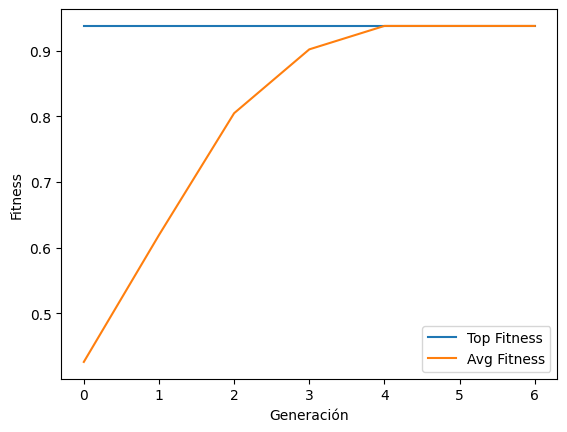

In [128]:
plt.plot(df_hist['fitness'], label='Top Fitness')
plt.plot(df_hist['Avg_Fitness'], label='Avg Fitness')
plt.xlabel('Generación')
plt.ylabel('Fitness')
plt.legend()
plt.show()

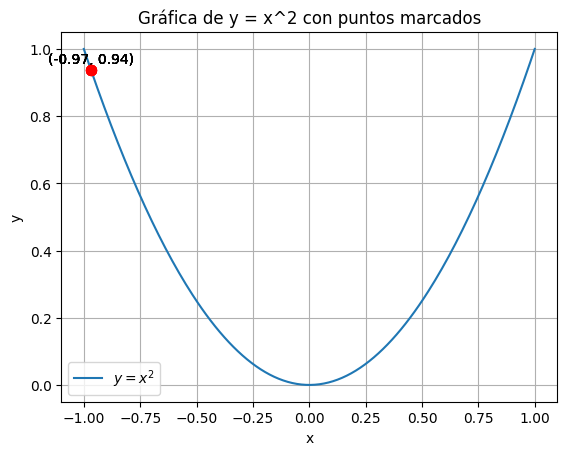

In [129]:
# Rango de x
x = np.linspace(-1, 1, 200)
y = x**2

pts_top_fitness = df_hist.loc[0:5, ['Valor', 'fitness']].to_numpy()

# Graficar la función
plt.plot(x, y, label='$y = x^2$')

# Marcar los puntos
for px, py in pts_top_fitness:
    plt.scatter(px, py, color='red', s=50, zorder=5)  # punto
    plt.text(px, py + 0.02, f"({px:.2f}, {py:.2f})", ha='center')  # etiqueta

plt.xlabel("x")
plt.ylabel("y")
plt.title("Gráfica de y = x^2 con puntos marcados")
plt.legend()
plt.grid(True)
plt.show()

# 2do Metodo de Cruza

In [130]:
display(df)

,Bin,Valor,fitness
0,000001,-0.968254,0.937516
1,111100,0.904762,0.818594
2,111001,0.809524,0.655329
3,001000,-0.746032,0.556563
4,110011,0.619048,0.383220
5,001110,-0.555556,0.308642
6,110000,0.523810,0.274376
7,010001,-0.460317,0.211892
8,010111,-0.269841,0.072814
9,011001,-0.206349,0.042580


In [131]:
def cruza_k_cortes(parejas, k):
    hijos = []
    for p1, p2 in parejas:
        bin1 = p1['Bin']
        bin2 = p2['Bin']
        L = len(bin1)
        if len(bin2) != L:
            raise ValueError("Los cromosomas deben tener la misma longitud.")
        if k < 1 or k >= L:
            raise ValueError("k debe estar entre 1 y longitud-1.")

        # Calcular tamaño de segmentos para tener k cortes → k+1 segmentos
        segment_size = L // (k + 1)

        # Dividir en segmentos
        segs1 = [bin1[i:i+segment_size] for i in range(0, L, segment_size)]
        segs2 = [bin2[i:i+segment_size] for i in range(0, L, segment_size)]

        # Alternar segmentos
        hijo1 = ''.join(segs1[i] if i % 2 == 0 else segs2[i] for i in range(len(segs1)))
        hijo2 = ''.join(segs2[i] if i % 2 == 0 else segs1[i] for i in range(len(segs2)))

        hijos.append(hijo1)
        hijos.append(hijo2)
    return hijos


In [139]:
parejas = parejas_tournament(df2)
hijos_binarios = cruza_k_cortes(parejas, 2)
for idx, (p1, p2) in enumerate(parejas):
    print(f"Pareja {idx+1}:")
    print("Padre 1 Bin:", p1['Bin'])
    print("Padre 2 Bin:", p2['Bin'])
    print("---")

for idx, hijo_bin in enumerate(hijos_binarios):
    print(f"Hijo {idx+1} Bin:", hijo_bin)

Pareja 1:
Padre 1 Bin: 110011
Padre 2 Bin: 011001
---
Pareja 2:
Padre 1 Bin: 001110
Padre 2 Bin: 010111
---
Pareja 3:
Padre 1 Bin: 110000
Padre 2 Bin: 010001
---
Hijo 1 Bin: 111011
Hijo 2 Bin: 010001
Hijo 3 Bin: 000110
Hijo 4 Bin: 011111
Hijo 5 Bin: 110000
Hijo 6 Bin: 010001


In [132]:
df_hist2 = pd.DataFrame(columns=["Bin","Valor","fitness", "Avg_Fitness"])
df_hist2 = add_hist(df, df_hist2)

C:\Users\death\AppData\Local\Temp\ipykernel_23728\3672471164.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_hist = pd.concat([df_hist, nuevo_registro], ignore_index=True)


## Ciclo

In [133]:
i = 0
for i in range(6): # Repetir el proceso de selección, cruza y reemplazo
    # Rank
    df1 = df.iloc[:4]
    # torneo
    df2 = df.iloc[4:10]


    # Cruza por rank
    parejas = parejas_rank(df1)
    hijos_binarios = cruza_k_cortes(parejas, 2)
    gen2_r = pd.DataFrame(hijos_binarios, columns=['Bin'])
    gen2_r['Valor'] = gen2_r['Bin'].apply(lambda b: bin2val(b, valores))
    gen2_r['fitness'] = gen2_r['Valor']**2
    gen2_r = pd.concat([df1.reset_index(drop=True), gen2_r], ignore_index=True)

    # Cruza por torneo
    parejas = parejas_tournament(df2)
    hijos_binarios = cruza_k_cortes(parejas, 2)
    gen2_t = pd.DataFrame(hijos_binarios, columns=['Bin'])
    gen2_t['Valor'] = gen2_t['Bin'].apply(lambda b: bin2val(b, valores))
    gen2_t['fitness'] = gen2_t['Valor']**2
    gen2_t = pd.concat([df2.reset_index(drop=True), gen2_t], ignore_index=True)


    # Unir y seleccionar los mejores 10
    gen2 = pd.concat([gen2_r, gen2_t], ignore_index=True)
    gen2.sort_values(by='fitness', ascending=False, inplace=True)
    gen2.reset_index(drop=True, inplace=True)
    gen2 = gen2.iloc[:10]
    
    # Registrar estadísticas
    print("Generación:", i)
    i += 1
    flag1 = gen2.iloc[[0]].copy()
    flag2 = gen2["fitness"].mean()
    print("Top Result:\n", flag1)
    print("Avg Fit:", flag2)
    df_hist2 = add_hist(gen2, df_hist2)

Generación: 0
Top Result:
       Bin     Valor   fitness
0  000001 -0.968254  0.937516
Avg Fit: 0.6325522801713277
Generación: 1
Top Result:
       Bin     Valor   fitness
0  000001 -0.968254  0.937516
Avg Fit: 0.6325522801713277
Generación: 2
Top Result:
       Bin     Valor   fitness
0  000001 -0.968254  0.937516
Avg Fit: 0.6325522801713277
Generación: 3
Top Result:
       Bin     Valor   fitness
0  000001 -0.968254  0.937516
Avg Fit: 0.6325522801713277
Generación: 4
Top Result:
       Bin     Valor   fitness
0  000001 -0.968254  0.937516
Avg Fit: 0.6325522801713277
Generación: 5
Top Result:
       Bin     Valor   fitness
0  000001 -0.968254  0.937516
Avg Fit: 0.6325522801713277


## Analisis

In [134]:
print(gen2)

      Bin     Valor   fitness
0  000001 -0.968254  0.937516
1  111100  0.904762  0.818594
2  111011  0.873016  0.762157
3  000110 -0.809524  0.655329
4  111001  0.809524  0.655329
5  111001  0.809524  0.655329
6  001000 -0.746032  0.556563
7  001000 -0.746032  0.556563
8  110011  0.619048  0.383220
9  001101 -0.587302  0.344923


In [135]:
print(df_hist2)

      Bin     Valor   fitness  Avg_Fitness
0  000001 -0.968254  0.937516     0.426153
1  000001 -0.968254  0.937516     0.632552
2  000001 -0.968254  0.937516     0.632552
3  000001 -0.968254  0.937516     0.632552
4  000001 -0.968254  0.937516     0.632552
5  000001 -0.968254  0.937516     0.632552
6  000001 -0.968254  0.937516     0.632552


### Grafica

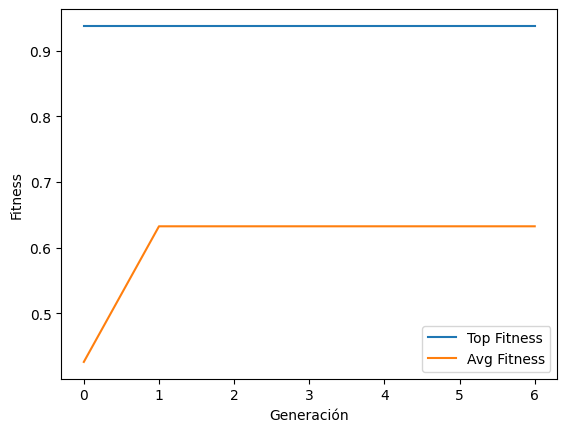

In [136]:
plt.plot(df_hist2['fitness'], label='Top Fitness')
plt.plot(df_hist2['Avg_Fitness'], label='Avg Fitness')
plt.xlabel('Generación')
plt.ylabel('Fitness')
plt.legend()
plt.show()